In this notebook, I apply the final preprocessing steps and the final models that were selected in the previous exploration notebooks. Unlike the exploration phase, all steps here are applied to both the training and test sets. At the end, I load the saved models from the exploration_2 notebook, train them on the full training data, and generate the final predictions for the test set.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/Energy Prediction/"

building_metadata = pd.read_csv(base_path + "building_metadata.csv")
train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")
weather_train = pd.read_csv(base_path + "weather_train.csv")
weather_test = pd.read_csv(base_path + "weather_test.csv")

In [ ]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
weather_train["timestamp"] = pd.to_datetime(weather_train["timestamp"])

test["timestamp"] = pd.to_datetime(test["timestamp"])
weather_test["timestamp"] = pd.to_datetime(weather_test["timestamp"])

In [ ]:
timezone_offsets = {
    0: 4, 1: 0, 2: 7, 3: 4, 4: 7, 5: 0, 6: 4,
    7: 4, 8: 4, 9: 5, 10: 7, 11: 4, 12: 0, 13: 5, 14: 4, 15: 4
}

weather_train["offset"] = weather_train["site_id"].map(timezone_offsets)
weather_train["timestamp"] = weather_train["timestamp"] - pd.to_timedelta(weather_train["offset"], unit="h")

weather_test["offset"] = weather_test["site_id"].map(timezone_offsets)
weather_test["timestamp"] = weather_test["timestamp"] - pd.to_timedelta(weather_test["offset"], unit="h")

weather_train.drop("offset", axis=1, inplace=True)
weather_test.drop("offset", axis=1, inplace=True)

In [ ]:
train_merged= train.merge(building_metadata, on= "building_id", how="left")
train_final= train_merged.merge(weather_train, on=["site_id","timestamp"], how="left")

test_merged= test.merge(building_metadata, on= "building_id", how="left")
test_final= test_merged.merge(weather_test, on=["site_id","timestamp"], how="left")

In [ ]:
train_final = train_final.astype({"building_id": "int32", "meter": "int8", "site_id": "int8", "meter_reading": "float32"})
test_final = test_final.astype({"building_id": "int32", "meter": "int8", "site_id": "int8"})
train_final["primary_use"] = train_final["primary_use"].astype("category")
test_final["primary_use"] = test_final["primary_use"].astype("category")

In [ ]:
def filter_anomalies(df,
                    drop_nonpositive=True,
                    jump_ratio_thresh=100,
                    zero_streak_max=48,
                    global_quantile=0.999,
                    verbose=True):

    n_start = len(df)

    if not np.issubdtype(df["timestamp"].dtype, np.datetime64):
        df["timestamp"] = pd.to_datetime(df["timestamp"])

    if drop_nonpositive:
        mask = df["meter_reading"] > 0
        if verbose:
            print(f"Dropping non-positive readings: {(~mask).sum():,}")
        df = df[mask]

    if "year_built" in df.columns:
        mask = df["year_built"].isna() | (df["timestamp"].dt.year >= df["year_built"])
        if verbose:
            print(f"Dropping readings before year_built: {(~mask).sum():,}")
        df = df[mask]


    df = df.sort_values(["building_id", "meter", "timestamp"]).reset_index(drop=True)

    def flag_long_constant_streaks(x, max_streak=zero_streak_max):
        diff = x.diff()
        constant_mask = (diff == 0)
        group_ids = (constant_mask != constant_mask.shift()).cumsum()
        streak_sizes = constant_mask.groupby(group_ids).transform("sum") + 1
        return constant_mask & (streak_sizes > max_streak)

    zero_streak_mask = df.groupby(["building_id", "meter"])["meter_reading"].transform(flag_long_constant_streaks)
    df.loc[zero_streak_mask, "meter_reading"] = np.nan
    if verbose:
        print(f"Set {zero_streak_mask.sum():,} readings to NaN due to long constant streaks")


    prev = df.groupby(["building_id", "meter"])["meter_reading"].shift(1)
    ratio = df["meter_reading"] / prev
    mask_jump = prev.isna() | ((ratio <= jump_ratio_thresh) & (ratio >= 1/jump_ratio_thresh))
    df = df[mask_jump]
    if verbose:
        print(f"Rows after jump filtering: {len(df):,}")

    def cap_building_spikes(x, low_quant=0.001, high_quant=global_quantile):
        if len(x) < 10:
            return x
        lower = x.quantile(low_quant)
        upper = x.quantile(high_quant)
        return np.clip(x, lower, upper)

    df["meter_reading"] = df.groupby(["building_id", "meter"])["meter_reading"].transform(cap_building_spikes)

    global_thresh = df["meter_reading"].quantile(global_quantile)
    mask_global = df["meter_reading"] < global_thresh
    if verbose:
        print(f"Removing {len(df) - mask_global.sum():,} rows above {global_quantile*100:.2f} percentile ({global_thresh:.2f})")
    df = df[mask_global].reset_index(drop=True)

    if verbose:
        print(f"Finished cleaning. Total rows: {len(df):,} "
              f"(dropped {n_start - len(df):,} rows, {100*((n_start - len(df)) / n_start):.2f}%)")
    return df

In [ ]:
train_final = filter_anomalies(train_final)

Dropping non-positive readings: 1,873,976
Dropping readings before year_built: 8,782
Set 258,941 readings to NaN due to long constant streaks
Rows after jump filtering: 18,313,044
Removing 275,628 rows above 99.90 percentile (41510.13)
Finished cleaning. Total rows: 18,037,416 (dropped 2,178,684 rows, 10.78%)


In [ ]:
train_final = train_final.sort_values(["building_id", "timestamp"])

def fill_meter_readings(group):
    group["meter_reading"] = group["meter_reading"].ffill().bfill()
    return group

train_final = (
    train_final
    .groupby("building_id", group_keys=False)
    .apply(fill_meter_readings)
)

def site_adjust(group):
    if group["meter_reading"].isna().any():
        median_readings = group.groupby("timestamp")["meter_reading"].transform("median")
        group["meter_reading"] = group["meter_reading"].fillna(median_readings)
    return group

train_final = (
    train_final
    .groupby("site_id", group_keys=False)
    .apply(site_adjust)
)


print("Remaining NaNs after filling:", train_final["meter_reading"].isna().sum())

/tmp/ipython-input-2414991534.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_meter_readings)


Remaining NaNs after filling: 0


/tmp/ipython-input-2414991534.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(site_adjust)


In [ ]:
train_final= train_final.drop("floor_count", axis=1)
test_final= test_final.drop("floor_count", axis=1)

In [ ]:
train_final["timestamp"]=pd.to_datetime(train_final['timestamp'])
train_final["hour"]=train_final["timestamp"].dt.hour
train_final["hour_sin"] = np.sin(2 * np.pi * train_final["hour"] / 24)
train_final["hour_cos"] = np.cos(2 * np.pi * train_final["hour"] / 24)
train_final["day_of_week"]=train_final["timestamp"].dt.dayofweek
train_final["month"]=train_final["timestamp"].dt.month
train_final["month_sin"] = np.sin(2 * np.pi * train_final["month"] / 12)
train_final["month_cos"] = np.cos(2 * np.pi * train_final["month"] / 12)
train_final["is_weekend"]=(train_final["day_of_week"]>=5).astype(int)

test_final["timestamp"]=pd.to_datetime(test_final["timestamp"])
test_final["hour"]=test_final["timestamp"].dt.hour
test_final["hour_sin"] = np.sin(2 * np.pi * test_final["hour"] / 24)
test_final["hour_cos"] = np.cos(2 * np.pi * test_final["hour"] / 24)
test_final["day_of_week"]=test_final["timestamp"].dt.dayofweek
test_final["month"]=test_final["timestamp"].dt.month
test_final["month_sin"] = np.sin(2 * np.pi * test_final["month"] / 12)
test_final["month_cos"] = np.cos(2 * np.pi * test_final["month"] / 12)
test_final["is_weekend"]=(test_final["day_of_week"]>=5).astype(int)

In [ ]:
train_final = train_final.sort_values(["site_id", "timestamp"])
test_final = test_final.sort_values(["site_id", "timestamp"])

train_final["sea_level_pressure"] = (
    train_final.groupby("site_id", group_keys=False)
    .apply(lambda g: g.set_index("timestamp")["sea_level_pressure"]
           .interpolate(method="time", limit_direction="both"))
    .reset_index(level=0, drop=True)
)

test_final["sea_level_pressure"] = (
    test_final.groupby("site_id", group_keys=False)
    .apply(lambda g: g.set_index("timestamp")["sea_level_pressure"]
           .interpolate(method="time", limit_direction="both"))
    .reset_index(level=0, drop=True)
)

train_final["sea_level_pressure"] = train_final.groupby("site_id")["sea_level_pressure"].transform(lambda x: x.fillna(train_final["sea_level_pressure"].median()))
test_final["sea_level_pressure"] = test_final.groupby("site_id")["sea_level_pressure"].transform(lambda x: x.fillna(test_final["sea_level_pressure"].median()))

train_final["sea_level_pressure"].isna().sum()
test_final["sea_level_pressure"].isna().sum()


/tmp/ipython-input-919438353.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('timestamp')['sea_level_pressure']
/tmp/ipython-input-919438353.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('timestamp')['sea_level_pressure']


np.int64(0)

In [ ]:
train_final["wind_speed"] = (
    train_final.groupby("site_id", group_keys=False)
    .apply(lambda g: g.set_index("timestamp")["wind_speed"]
           .interpolate(method="time", limit_direction="both"))
    .reset_index(level=0, drop=True)
)

test_final["wind_speed"] = (
    test_final.groupby("site_id", group_keys=False)
    .apply(lambda g: g.set_index("timestamp")["wind_speed"]
           .interpolate(method="time", limit_direction="both"))
    .reset_index(level=0, drop=True)
)

train_final["wind_speed"] = train_final.groupby("site_id")["wind_speed"].transform(lambda x: x.rolling(3, min_periods=1, center=True).mean())
test_final["wind_speed"] = test_final.groupby("site_id")["wind_speed"].transform(lambda x: x.rolling(3, min_periods=1, center=True).mean())

train_final["wind_speed"].isna().sum()
test_final["wind_speed"].isna().sum()

/tmp/ipython-input-1026062845.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('timestamp')['wind_speed']
/tmp/ipython-input-1026062845.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('timestamp')['wind_speed']


np.int64(0)

In [ ]:
train_final["wind_dir_sin"] = np.sin(np.deg2rad(train_final["wind_direction"]))
train_final["wind_dir_cos"] = np.cos(np.deg2rad(train_final["wind_direction"]))

train_final["wind_dir_sin"] = train_final.groupby("site_id")["wind_dir_sin"].transform(lambda x: x.interpolate())
train_final["wind_dir_cos"] = train_final.groupby("site_id")["wind_dir_cos"].transform(lambda x: x.interpolate())

train_final["wind_dir_sin"] = train_final.groupby("site_id")["wind_dir_sin"].transform(lambda x: x.ffill().bfill())
train_final["wind_dir_cos"] = train_final.groupby("site_id")["wind_dir_cos"].transform(lambda x: x.ffill().bfill())

train_final["wind_dir_sin"].isna().sum()
train_final["wind_dir_cos"].isna().sum()

test_final["wind_dir_sin"] = np.sin(np.deg2rad(test_final["wind_direction"]))
test_final["wind_dir_cos"] = np.cos(np.deg2rad(test_final["wind_direction"]))

test_final["wind_dir_sin"] = test_final.groupby("site_id")["wind_dir_sin"].transform(lambda x: x.interpolate())
test_final["wind_dir_cos"] = test_final.groupby("site_id")["wind_dir_cos"].transform(lambda x: x.interpolate())

test_final["wind_dir_sin"] = test_final.groupby("site_id")["wind_dir_sin"].transform(lambda x: x.ffill().bfill())
test_final["wind_dir_cos"] = test_final.groupby("site_id")["wind_dir_cos"].transform(lambda x: x.ffill().bfill())

test_final["wind_dir_sin"].isna().sum()
test_final["wind_dir_cos"].isna().sum()

np.int64(0)

In [ ]:
train_final = train_final.sort_values(["site_id", "timestamp"])
test_final = test_final.sort_values(["site_id", "timestamp"])

def interpolate_precip(group):
    group = group.set_index("timestamp")  # <- necessary for time-based interpolation
    group["precip_depth_1_hr"] = group["precip_depth_1_hr"].apply(lambda x: np.nan if x < 0 else x)
    group["precip_depth_1_hr"] = group["precip_depth_1_hr"].interpolate(method="time", limit_direction="both")
    group["precip_depth_1_hr"] = group["precip_depth_1_hr"].ffill().bfill()
    return group.reset_index()

train_final = train_final.groupby("site_id", group_keys=False).apply(interpolate_precip)
test_final = test_final.groupby("site_id", group_keys=False).apply(interpolate_precip)

train_final["precip_depth_1_hr"] = train_final["precip_depth_1_hr"].fillna(0)
test_final["precip_depth_1_hr"] = test_final["precip_depth_1_hr"].fillna(0)

train_final["precip_depth_1_hr"].isna().mean()
test_final["precip_depth_1_hr"].isna().mean()

/tmp/ipython-input-4077600213.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_final = train_final.groupby('site_id', group_keys=False).apply(interpolate_precip)
/tmp/ipython-input-4077600213.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_final = test_final.groupby('site_id', group_keys=False).apply(interpolate_precip)


np.float64(0.0)

In [ ]:
site_hour_median = train_final.groupby(["site_id", "hour"])["cloud_coverage"].median().rename("median")

keys_train = pd.MultiIndex.from_frame(train_final[["site_id", "hour"]])
median_aligned_train = pd.Series(site_hour_median.reindex(keys_train).values, index=train_final.index)

train_final["cloud_coverage"] = train_final["cloud_coverage"].fillna(median_aligned_train)

hour_median_train = train_final.groupby("hour")["cloud_coverage"].median()
train_final["cloud_coverage"] = train_final["cloud_coverage"].fillna(train_final["hour"].map(hour_median_train))


site_hour_median_test = test_final.groupby(["site_id", "hour"])["cloud_coverage"].median().rename("median")
keys_test = pd.MultiIndex.from_frame(test_final[["site_id", "hour"]])
median_aligned_test = pd.Series(site_hour_median_test.reindex(keys_test).values, index=test_final.index)

test_final["cloud_coverage"] = test_final["cloud_coverage"].fillna(median_aligned_test)

hour_median_test = test_final.groupby("hour")["cloud_coverage"].median()
test_final["cloud_coverage"] = test_final["cloud_coverage"].fillna(test_final["hour"].map(hour_median_test))

print("Train missing proportion:", train_final["cloud_coverage"].isna().mean())
print("Test missing proportion:", test_final["cloud_coverage"].isna().mean())

Train missing proportion: 0.0
Test missing proportion: 0.0


In [ ]:
global_year_built_median=train_final["year_built"].median()

site_year_built_medians=train_final.groupby("site_id")["year_built"].median()

site_year_built_medians=site_year_built_medians.fillna(global_year_built_median)

train_final["site_year_built_medians"]=train_final["site_id"].map(site_year_built_medians)

train_final["year_built"]=train_final["year_built"].fillna(train_final["site_year_built_medians"])

train_final=train_final.drop("site_year_built_medians", axis=1)

train_final["year_built"].isna().sum()

np.int64(0)

In [ ]:
global_year_built_median=test_final["year_built"].median()

site_year_built_medians=test_final.groupby("site_id")["year_built"].median()

site_year_built_medians=site_year_built_medians.fillna(global_year_built_median)

test_final["site_year_built_medians"]=test_final["site_id"].map(site_year_built_medians)

test_final["year_built"]=test_final["year_built"].fillna(test_final["site_year_built_medians"])

test_final=test_final.drop("site_year_built_medians", axis=1)

test_final["year_built"].isna().sum()


np.int64(0)

In [ ]:
bins = [1900, 1950, 1980, 2000, 2011, 2018]
labels = ["Before1950", "1950-1979", "1980-1999", "2000-2010", "After2010"]
train_final["building_age_group"] = pd.cut(train_final["year_built"], bins=bins, labels=labels)
test_final["building_age_group"] = pd.cut(test_final["year_built"], bins=bins, labels=labels)

In [ ]:
train_final["building_age_group"] = train_final["building_age_group"].astype("category")
train_final["building_age_group"] = train_final["building_age_group"].cat.add_categories(["Unknown"])
train_final["building_age_group"] = train_final["building_age_group"].fillna("Unknown")

test_final["building_age_group"] = test_final["building_age_group"].astype("category")
test_final["building_age_group"] = test_final["building_age_group"].cat.add_categories(["Unknown"])
test_final["building_age_group"] = test_final["building_age_group"].fillna("Unknown")

In [ ]:
train_final["air_temp_wind"] = train_final["air_temperature"] * train_final["wind_speed"]
train_final["air_temp_cloud"] = train_final["air_temperature"] * train_final["cloud_coverage"]
train_final["dew_temp_wind"] = train_final["dew_temperature"] * train_final["wind_speed"]

test_final["air_temp_wind"] = test_final["air_temperature"] * test_final["wind_speed"]
test_final["air_temp_cloud"] = test_final["air_temperature"] * test_final["cloud_coverage"]
test_final["dew_temp_wind"] = test_final["dew_temperature"] * test_final["wind_speed"]

In [ ]:
train_final = train_final.drop(
    ["timestamp", "hour", "month", "year_built", "wind_direction"],
    axis=1
)

test_final = test_final.drop(
    ["timestamp", "hour", "month", "year_built", "wind_direction"],
    axis=1
)

In [ ]:
for col in train_final.select_dtypes(include=["float64"]).columns:
    train_final[col] = train_final[col].astype("float32")
for col in train_final.select_dtypes(include=["int64"]).columns:
    train_final[col] = train_final[col].astype("int32")

for col in test_final.select_dtypes(include=["float64"]).columns:
    test_final[col] = test_final[col].astype("float32")
for col in test_final.select_dtypes(include=["int64"]).columns:
    test_final[col] = test_final[col].astype("int32")

In [ ]:
X_train = train_final.drop(columns=["meter_reading"])
y_train = train_final["meter_reading"]

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train_encoded = X_train.copy()
X_test_encoded = test_final.copy()

building_encoders = {}

sites = X_train_encoded["site_id"].unique()

for site in sites:
    le = LabelEncoder()
    train_mask = X_train_encoded["site_id"] == site
    test_mask = X_test_encoded["site_id"] == site

    le.fit(X_train_encoded.loc[train_mask, "building_id"])
    building_encoders[site] = le

    X_train_encoded.loc[train_mask, "building_id"] = le.transform(
        X_train_encoded.loc[train_mask, "building_id"]
    )

    known_classes = pd.Series(np.arange(len(le.classes_)), index=le.classes_)
    X_test_encoded.loc[test_mask, "building_id"] = (
        X_test_encoded.loc[test_mask, "building_id"]
        .map(known_classes)
        .fillna(len(le.classes_))
        .astype(int)
    )

print("Building ID encoding complete.")

/tmp/ipython-input-3939726168.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 46  74  93 ... 102 103 104]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train_encoded.loc[train_mask, 'building_id'] = le.transform(
/tmp/ipython-input-3939726168.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0   1   2 ...  91 101 102]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_test_encoded.loc[test_mask, 'building_id'] = (


Building ID encoding complete.


In [ ]:
selected_features= ["building_id", "meter", "site_id", "primary_use", "square_feet",
       "air_temperature", "cloud_coverage", "dew_temperature",
       "precip_depth_1_hr", "sea_level_pressure", "wind_speed", "hour_sin",
       "hour_cos", "day_of_week", "month_sin", "month_cos", "is_weekend",
       "wind_dir_sin", "wind_dir_cos", "building_age_group", "air_temp_wind",
       "air_temp_cloud", "dew_temp_wind"]

cat_cols_site = ["primary_use", "building_age_group", "meter", "building_id"]

numerical_features= ["square_feet",
       "air_temperature", "cloud_coverage", "dew_temperature",
       "precip_depth_1_hr", "sea_level_pressure", "wind_speed", "hour_sin",
       "hour_cos", "day_of_week", "month_sin", "month_cos", "is_weekend",
       "wind_dir_sin", "wind_dir_cos", "air_temp_wind",
       "air_temp_cloud", "dew_temp_wind"]

In [ ]:
assert (X_test_encoded.index == test_final.index).all()

In [ ]:
X_train_final = X_train_encoded[selected_features]
X_test_final = X_test_encoded[selected_features]
row_ids = X_test_encoded["row_id"]

### Train Final Models per Site
In this step, the final models for each site are trained using the best parameters and model types identified in the exploration notebooks. For each site:

* Site-specific training data is selected.

* Categorical columns are converted to the appropriate type.

* The final regressor (XGBoost or LightGBM) is initialized and wrapped with a log-transform.

* The model is trained on the full site data and saved.

All trained models are stored in a dictionary and exported to Google Drive for later use in predictions.

In [ ]:
import joblib
import gc
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load best parameters and model types per site
best_params_dict = joblib.load("/content/drive/MyDrive/best_params_per_site.pkl")
best_models = joblib.load("/content/drive/MyDrive/best_models_per_site.pkl")

final_models = {}

for site in range(16):
    print(f"\n=== Training final model for Site {site} ===")

    # Select site specific training data
    mask = X_train_final["site_id"] == site
    if mask.sum() == 0:
        print(f"Skipping site {site}: no data")
        continue

    X_train_site = X_train_final[mask].drop(columns=["site_id"])
    y_train_site = y_train[mask]

    # Select site-specific training data
    for col in cat_cols_site:
        if col in X_train_site.columns:
            X_train_site[col] = X_train_site[col].astype("category")

    # Get the best hyperparameters for the site
    params = best_params_dict.get(site)
    if params is None:
        print(f"No parameters found for site {site}, skipping.")
        continue

    # Initialize model type
    model_type = best_models.get(f"site_{site}", {}).get("type")
    if model_type not in ["XGBoost", "LightGBM"]:
        print(f"Unknown model type for site {site}, skipping.")
        continue

    # Create the regressor with best params
    if model_type == "XGBoost":
        regressor = XGBRegressor(
            enable_categorical=True,
            tree_method="hist",
            random_state=42 + site,
            eval_metric="rmsle"
        )
    else:
        regressor = LGBMRegressor(
            random_state=42 + site,
            metric="rmsle",
            verbosity=-1
        )

    # Apply best hyperparameters
    regressor.set_params(**{
        k.replace("regressor__", ""): v for k, v in params.items() if "regressor__" in k
    })

    # Wrap with log transform
    model = TransformedTargetRegressor(
        regressor=regressor,
        func=np.log1p,
        inverse_func=np.expm1,
        check_inverse=False
    )

    # Train model on full site data
    model.fit(X_train_site, y_train_site)
    print(f" Site {site} final model trained successfully! ({model_type})")

    # Save model in dictionary
    final_models[f"site_{site}"] = {
        "model": model,
        "type": model_type
    }

    # Clear memory
    gc.collect()

# Save all final site models to Drive
joblib.dump(final_models, "/content/drive/MyDrive/final_models_per_site.pkl")
print("\n All site models trained and saved successfully to Google Drive!")


=== Training final model for Site 0 ===
 Site 0 final model trained successfully! (XGBoost)

=== Training final model for Site 1 ===
 Site 1 final model trained successfully! (XGBoost)

=== Training final model for Site 2 ===
 Site 2 final model trained successfully! (XGBoost)

=== Training final model for Site 3 ===
 Site 3 final model trained successfully! (XGBoost)

=== Training final model for Site 4 ===
 Site 4 final model trained successfully! (LightGBM)

=== Training final model for Site 5 ===
 Site 5 final model trained successfully! (LightGBM)

=== Training final model for Site 6 ===
 Site 6 final model trained successfully! (LightGBM)

=== Training final model for Site 7 ===
 Site 7 final model trained successfully! (LightGBM)

=== Training final model for Site 8 ===
 Site 8 final model trained successfully! (XGBoost)

=== Training final model for Site 9 ===
 Site 9 final model trained successfully! (LightGBM)

=== Training final model for Site 10 ===
 Site 10 final model tr

* There was one building id in the test set for site 3 that was not seen in the training data, which caused an error during prediction. To fix this, any test buildings not seen in training were replaced with a known building id from the same site.

In [ ]:
site = 3
train_buildings = set(X_train_encoded.loc[X_train_encoded["site_id"] == site, "building_id"])
known_building = list(train_buildings)[0]  # pick the first known one

mask_site3 = X_test_final["site_id"] == site
X_test_final.loc[
    mask_site3 & ~X_test_final["building_id"].isin(train_buildings),
    "building_id"
] = known_building

### Generate Predictions for Test Set

In this step, the saved final models are loaded and used to generate site-wise predictions on the test set:

* Each site’s test data is selected and prepared.

* Categorical columns are converted to the correct type for the model.

* Predictions are made using the corresponding trained model and clipped to avoid negative values.

* Predictions for all sites are combined into a single submission file and saved to Google Drive.

In [ ]:
# Load saved models
final_models = joblib.load("/content/drive/MyDrive/final_models_per_site.pkl")

# Prepare predictions
all_preds = []
all_row_ids = []


# Ensure site_id is available in X_test_final
if "site_id" not in X_test_final.columns:
    raise ValueError("X_test_final must include 'site_id' column for site-wise predictions.")

# Prediction loop per site
for site in range(16):
    print(f"\n=== Predicting Site {site} ===")

    # Filter site data
    mask = X_test_final["site_id"] == site
    if mask.sum() == 0:
        print(f"Skipping site {site}: no data")
        continue

    X_test_site = X_test_final[mask].drop(columns=["site_id"])
    site_row_ids = row_ids[mask].values

    model_entry = final_models.get(f"site_{site}")
    if model_entry is None:
        print(f"No trained model found for site {site}, skipping.")
        continue

    model = model_entry["model"]
    model_type = model_entry["type"]

    # Ensure categorical columns are of the right dtype
    for col in cat_cols_site:
        if col in X_test_site.columns:
            X_test_site[col] = X_test_site[col].astype("category")

    # Predict
    y_pred_site = model.predict(X_test_site)
    y_pred_site = np.clip(y_pred_site, 0, None)  # prevent negative meter readings

    # Save predictions
    all_preds.append(pd.DataFrame({
        "row_id": site_row_ids,
        "meter_reading": y_pred_site
    }))

    print(f" Site {site} predictions complete! ({len(y_pred_site)} rows)")

    gc.collect()

# Combine all site predictions
submission = pd.concat(all_preds, axis=0)
submission = submission.sort_values("row_id").reset_index(drop=True)

# Save submission to Drive
submission_path = "/content/drive/MyDrive/final_submission.csv"
submission.to_csv(submission_path, index=False)

print("\n All predictions complete!")
print(f"Submission saved to: {submission_path}")
display(submission.head())



=== Predicting Site 0 ===
 Site 0 predictions complete! (2260080 rows)

=== Predicting Site 1 ===
 Site 1 predictions complete! (1103760 rows)

=== Predicting Site 2 ===
 Site 2 predictions complete! (5063280 rows)

=== Predicting Site 3 ===
 Site 3 predictions complete! (4800480 rows)

=== Predicting Site 4 ===
 Site 4 predictions complete! (1594320 rows)

=== Predicting Site 5 ===
 Site 5 predictions complete! (1559280 rows)

=== Predicting Site 6 ===
 Site 6 predictions complete! (1401600 rows)

=== Predicting Site 7 ===
 Site 7 predictions complete! (735840 rows)

=== Predicting Site 8 ===
 Site 8 predictions complete! (1226400 rows)

=== Predicting Site 9 ===
 Site 9 predictions complete! (5361120 rows)

=== Predicting Site 10 ===
 Site 10 predictions complete! (876000 rows)

=== Predicting Site 11 ===
 Site 11 predictions complete! (245280 rows)

=== Predicting Site 12 ===
 Site 12 predictions complete! (630720 rows)

=== Predicting Site 13 ===
 Site 13 predictions complete! (54

,row_id,meter_reading
0,0,102.023376
1,1,17.220369
2,2,0.606231
3,3,152.492081
4,4,275.572174


In [ ]:
print("Submission shape:", submission.shape)
print("Unique row_ids:", submission["row_id"].nunique())

Submission shape: (41697600, 2)
Unique row_ids: 41697600


In [ ]:
print(submission['meter_reading'].describe())

count    4.169760e+07
mean     3.996361e+02
std      1.448601e+03
min      0.000000e+00
25%      2.707708e+01
50%      8.933724e+01
75%      2.778954e+02
max      8.699473e+04
Name: meter_reading, dtype: float64


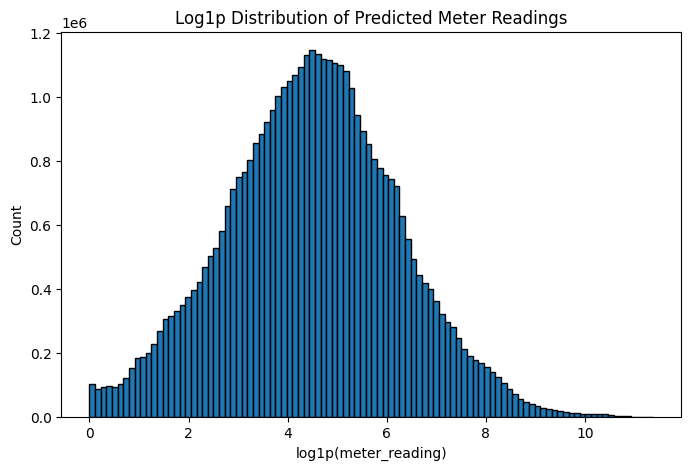

In [ ]:
# Visualize the distribution of predicted meter readings after applying log1p transformation
plt.figure(figsize=(8,5))
plt.hist(np.log1p(submission["meter_reading"]), bins=100, edgecolor="k")
plt.title("Log1p Distribution of Predicted Meter Readings")
plt.xlabel("log1p(meter_reading)")
plt.ylabel("Count")
plt.show()